# Support Vector Machine (SVM)

Classification of beans in species using SVM based on most important features according to the info provided by the optimal random forest, and with imbalanced or balanced (oversampled) data.

In [18]:
# Installing dependencies
import pickle
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
# Fetching processed datasets
with open('X_train', 'rb') as file: X_train = pickle.load(file)
with open('y_train', 'rb') as file: y_train = np.ravel(pickle.load(file))
with open('X_test' , 'rb') as file: X_test  = pickle.load(file)
with open('y_test' , 'rb') as file: y_test  = pickle.load(file)
with open('best_rf_clf.pkl', 'rb') as file: best_rf_clf = pickle.load(file)

In [3]:
# Sorting features by importance provided by the optimal random forest
features_dict = dict(enumerate(best_rf_clf.feature_importances_))
features_list = sorted(features_dict.items(), key = lambda item: item[1], reverse = True)
features_list

[(2, 0.3142879027641842),
 (3, 0.1648580501373519),
 (12, 0.13808776116926594),
 (14, 0.08173824405512492),
 (11, 0.08022147851974754),
 (1, 0.05958046565876466),
 (10, 0.047421763420313255),
 (15, 0.02583965423737132),
 (6, 0.01612903611346848),
 (7, 0.015260908597228853),
 (0, 0.014314709326667466),
 (9, 0.012900469224532364),
 (8, 0.00849707138253093),
 (13, 0.008284226719571824),
 (4, 0.007139114650114524),
 (5, 0.00543914402376185)]

### Support Vector Machine with imbalanced classes

In [14]:
# Defining the hyperparameter distribution for grid search
param_grid = {'C': [1, 5, 20, 50, 100, 250, 500],
              'gamma': [0.01, 0.5, 1, 2, "scale"],
              'kernel': ['rbf', 'sigmoid']}

In [6]:
# Setting the random search

def calculate_metrics(y_test, y_pred):
    """Calculating scoring metrics"""
    precision = round(precision_score(y_test, y_pred, average='weighted'), 4)
    recall = round(recall_score(y_test, y_pred, average='weighted'), 4)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 4)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    return [precision, recall, f1, accuracy]

svc = SVC(random_state=42)
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)
features_train = []
results_df1 = pd.DataFrame(columns = ['C', 'gamma', 'kernel'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature added'])

with tqdm(total=len(features_list)) as progress_bar:
    for feature_index, feature_importance in features_list: # Feeding new features by importance in each interation
        
        # Optimizing the hyperparameters
        features_train.append(feature_index)
        X_train_temp = X_train.iloc[:,features_train]
        grid_search.fit(X_train_temp, y_train)
        best_svc = grid_search.best_estimator_
        results_df1.loc[len(features_train)] = [best_svc.get_params()[key] for key in ['C', 'gamma', 'kernel']]
    
        # Evaluating the model
        y_pred = best_svc.predict(X_test.iloc[:,features_train])
        feature = X_train.columns[feature_index]
        results_df2.loc[len(features_train)] = calculate_metrics(y_test, y_pred) + [feature]
        progress_bar.update(1)

results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

  0%|          | 0/16 [00:00<?, ?it/s]

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits


,C,gamma,kernel,Precision,Recall,F1 score,Accuracy,Feature added
1,250,2,rbf,0.5283,0.5821,0.5349,0.5821,MajorAxisLength
2,250,scale,rbf,0.8790,0.8787,0.8780,0.8787,MinorAxisLength
3,20,scale,rbf,0.8788,0.8782,0.8779,0.8782,ShapeFactor1
4,50,scale,rbf,0.8793,0.8789,0.8786,0.8789,ShapeFactor3
5,50,scale,rbf,0.8784,0.8779,0.8776,0.8779,Compactness
6,500,scale,rbf,0.9131,0.9126,0.9127,0.9126,Perimeter
7,500,scale,rbf,0.9129,0.9124,0.9124,0.9124,Roundness
8,500,scale,rbf,0.9126,0.9121,0.9122,0.9121,ShapeFactor4
9,500,scale,rbf,0.7287,0.6931,0.6578,0.6931,ConvexArea
10,500,scale,rbf,0.7286,0.6926,0.6570,0.6926,EquivDiameter


Without doubt, best hyperparameters are {'C': 250, 'gamma': 'scale', 'kernel': 'rbf'}. Deductions extracted are in line with those of the results of the KNN algorithm, but in this case 'ShapeFactor1' and 'ShapeFactor3' features slightly improve the metrics while 'Compactness' one makes them worse. Therefore, let's check how the model performance changes when eliminating this last one feature, along with, or not, the shape factors.

In [13]:
# Evaluating the model performance with 'MajorAxisLength', 'MinorAxisLength', 'ShapeFactor1', 'ShapeFactor3', and 'Perimeter' features
results_df1 = pd.DataFrame(columns = ['C', 'gamma', 'kernel'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature extra'])
features_important = ['MajorAxisLength', 'MinorAxisLength', 'Perimeter']
features_extra = [[], ['ShapeFactor1'], ['ShapeFactor3'], ['ShapeFactor1', 'ShapeFactor3']]

with tqdm(total=len(features_extra)) as progress_bar:
    for i, feature in enumerate(features_extra):
    
        # Optimizing the hyperparameters
        features_selected = features_important + feature
        X_train_temp = X_train.loc[:,features_selected]
        grid_search.fit(X_train_temp, y_train)
        results_df1.loc[i] = grid_search.best_params_
        
        # Evaluating the model
        best_clf = grid_search.best_estimator_
        y_pred = best_clf.predict(X_test.loc[:,features_selected])
        results_df2.loc[i] = calculate_metrics(y_test, y_pred) + [feature]
        progress_bar.update(1)
    
results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits


,C,gamma,kernel,Precision,Recall,F1 score,Accuracy,Feature extra
0,100,scale,rbf,0.9131,0.9126,0.9127,0.9126,[]
1,250,scale,rbf,0.9131,0.9126,0.9127,0.9126,[ShapeFactor1]
2,500,scale,rbf,0.9146,0.9141,0.9142,0.9141,[ShapeFactor3]
3,250,scale,rbf,0.9129,0.9124,0.9124,0.9124,"[ShapeFactor1, ShapeFactor3]"


For this model, the 'ShapeFactor3' feature turns to be informative and also non-redundant (negative correlation with the rest of features used: 'MajorAxisLength', 'MinorAxisLength', and 'Perimeter'). Notice that C (regularization) increases as one non-correlated feature is introduced.

In [15]:
# Creating and evaluating the optimal model by class

def calculate_metrics_classes(y_test, y_pred):
    """Calculating scoring metrics by class"""
    results_df_class = pd.DataFrame(columns = sorted(set(y_test['Class'])))
    results_df_class.loc['Precision'] = np.around(precision_score(y_test, y_pred, average=None), decimals = 4)
    results_df_class.loc['Recall'] = np.around(recall_score(y_test, y_pred, average=None), decimals = 4)
    results_df_class.loc['F1 score'] = np.around(f1_score(y_test, y_pred, average=None), decimals = 4)
    return results_df_class

X_train_temp = X_train.loc[:,['MajorAxisLength', 'MinorAxisLength', 'ShapeFactor3', 'Perimeter']]
grid_search.fit(X_train_temp, y_train)
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test.loc[:,['MajorAxisLength', 'MinorAxisLength', 'ShapeFactor3', 'Perimeter']])
results_df_class = calculate_metrics_classes(y_test, y_pred)
results_df_class

Fitting 5 folds for each of 70 candidates, totalling 350 fits


,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Precision,0.9227,1.0,0.9002,0.9105,0.9608,0.9462,0.8506
Recall,0.8737,1.0,0.9345,0.9268,0.9313,0.9385,0.8570
F1 score,0.8975,1.0,0.9170,0.9186,0.9458,0.9423,0.8538


### Support Vector Machine with balanced classes

In [16]:
# Defining the hyperparameter distribution for grid search
param_grid = {'svc__C': [1, 5, 20, 50, 100, 250, 500],
              'svc__gamma': [0.01, 0.5, 1, 2, "scale"],
              'svc__kernel': ['rbf', 'sigmoid']}

In [19]:
# After oversampling the training data with SMOTE, AGAIN finding and evaluating the optimal model
svc_clf = SVC(random_state=42)
smote = SMOTE(random_state=42)
pipeline = Pipeline([("smote", SMOTE()), ("svc", svc_clf)])
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_balanced = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf, scoring='f1_weighted', verbose=1, n_jobs=-1)

features_train = []
results_df1 = pd.DataFrame(columns = ['svc__metric', 'svc__n_neighbors', 'svc__weights'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature added'])

with tqdm(total=len(features_list)) as progress_bar:
    for feature_index, feature_importance in features_list:
        
        # Optimizing the hyperparameters
        features_train.append(feature_index)
        X_train_temp = X_train.iloc[:,features_train]
        grid_search_balanced.fit(X_train_temp, y_train)
        results_df1.loc[len(features_train)] = grid_search_balanced.best_params_
    
        # Evaluating the model
        best_clf_balanced = grid_search_balanced.best_estimator_
        y_pred_balanced = best_clf_balanced.predict(X_test.iloc[:,features_train])
        feature = X_train.columns[feature_index]
        results_df2.loc[len(features_train)] = calculate_metrics(y_test, y_pred_balanced) + [feature]
        progress_bar.update(1)

results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

  0%|          | 0/16 [00:00<?, ?it/s]

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits


,knn__metric,knn__n_neighbors,knn__weights,Precision,Recall,F1 score,Accuracy,Feature added
1,NaN,NaN,NaN,0.5495,0.5437,0.5414,0.5437,MajorAxisLength
2,NaN,NaN,NaN,0.8768,0.8760,0.8761,0.8760,MinorAxisLength
3,NaN,NaN,NaN,0.8758,0.8750,0.8751,0.8750,ShapeFactor1
4,NaN,NaN,NaN,0.8761,0.8750,0.8752,0.8750,ShapeFactor3
5,NaN,NaN,NaN,0.8773,0.8764,0.8765,0.8764,Compactness
6,NaN,NaN,NaN,0.9082,0.9072,0.9075,0.9072,Perimeter
7,NaN,NaN,NaN,0.9068,0.9060,0.9062,0.9060,Roundness
8,NaN,NaN,NaN,0.9079,0.9075,0.9076,0.9075,ShapeFactor4
9,NaN,NaN,NaN,0.7242,0.7101,0.7098,0.7101,ConvexArea
10,NaN,NaN,NaN,0.7227,0.7088,0.7086,0.7088,EquivDiameter


On a first inspection, model's performance does not improve when trained on balanced data. Let's investigate if some features with high-repeated entries may cause overfitting: for next models features reducing the metric scores ('ShapeFactor1', 'Roundness') are eliminated, the features after the eliminated ones that are incrementing again the metric scores, but not higher than the previous best state ('ShapeFactor3', 'ShapeFactor4') are included or not.

In [21]:
# Evaluating the model performance with 'MajorAxisLength', 'MinorAxisLength', 'ShapeFactor1', 'ShapeFactor3', and 'Perimeter' features
results_df1 = pd.DataFrame(columns = ['C', 'gamma', 'kernel'])
results_df2 = pd.DataFrame(columns = ['Precision', 'Recall', 'F1 score', 'Accuracy', 'Feature extra'])
features_important = ['MajorAxisLength', 'MinorAxisLength', 'Compactness', 'Perimeter']
features_extra = [[], ['ShapeFactor3'], ['ShapeFactor4'], ['ShapeFactor3', 'ShapeFactor4']]

with tqdm(total=len(features_extra)) as progress_bar:
    for i, feature in enumerate(features_extra):
    
        # Optimizing the hyperparameters
        features_selected = features_important + feature
        X_train_temp = X_train.loc[:,features_selected]
        grid_search.fit(X_train_temp, y_train)
        results_df1.loc[i] = grid_search.best_params_
        
        # Evaluating the model
        best_clf = grid_search.best_estimator_
        y_pred = best_clf.predict(X_test.loc[:,features_selected])
        results_df2.loc[i] = calculate_metrics(y_test, y_pred) + [feature]
        progress_bar.update(1)
    
results_df = pd.concat([results_df1, results_df2], axis = 1)
results_df

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits
Fitting 5 folds for each of 70 candidates, totalling 350 fits


,C,gamma,kernel,Precision,Recall,F1 score,Accuracy,Feature extra
0,250,scale,rbf,0.9131,0.9126,0.9127,0.9126,[]
1,250,scale,rbf,0.9129,0.9124,0.9124,0.9124,[ShapeFactor3]
2,250,scale,rbf,0.9129,0.9124,0.9124,0.9124,[ShapeFactor4]
3,500,scale,rbf,0.9131,0.9126,0.9127,0.9126,"[ShapeFactor3, ShapeFactor4]"


The model acquires better performance than before without 'ShapeFactor1' and 'Roundness' features. Moreover, 'ShapeFactor3' and 'ShapeFactor4' (correlated) can be removed as they are not informative. However, model trained on imbalanced data has better performance, but same number of metrics ('Compactness' instead of 'ShapeFactor3').

In [23]:
# Creating and evaluating the optimal model by class
best_clf_balanced = SVC(C=250, gamma='scale', kernel='rbf', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
X_train_temp = X_train_balanced.loc[:,['MajorAxisLength', 'MinorAxisLength', 'Compactness', 'Perimeter']]
best_clf_balanced.fit(X_train_temp, y_train_balanced)
y_pred_balanced = best_clf_balanced.predict(X_test.loc[:,['MajorAxisLength', 'MinorAxisLength', 'Compactness', 'Perimeter']])
results_df_class = calculate_metrics_classes(y_test, y_pred_balanced)
results_df_class

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Precision,0.9160,1.0,0.9039,0.9226,0.9487,0.9211,0.8339
Recall,0.8813,1.0,0.9345,0.8948,0.9367,0.9450,0.8570
F1 score,0.8983,1.0,0.9189,0.9085,0.9427,0.9329,0.8453


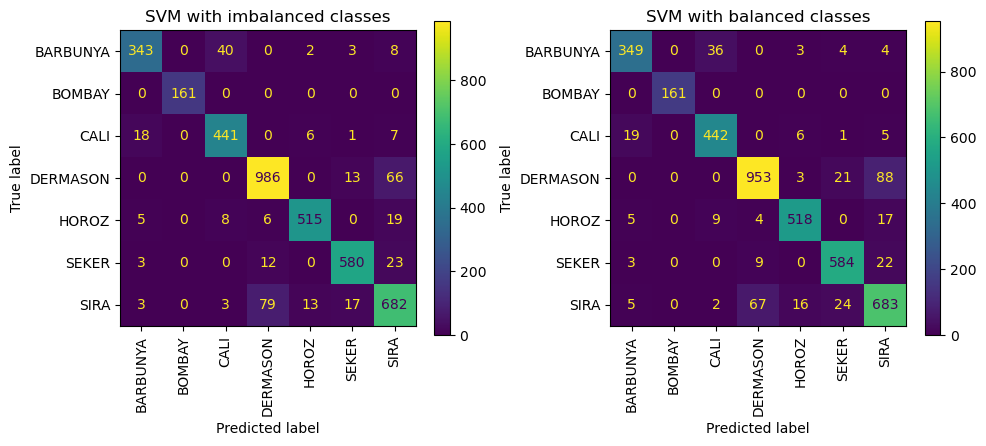

In [24]:
# Plotting confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 16))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = sorted(set(y_test['Class'])))
disp.plot(ax=axes[0], colorbar = False)
axes[0].set_title('SVM with imbalanced classes')
axes[0].tick_params(axis='x', rotation=90)
plt.colorbar(disp.im_, ax=axes[0], shrink=0.2)

cm = confusion_matrix(y_test, y_pred_balanced)
disp = ConfusionMatrixDisplay(cm, display_labels = sorted(set(y_test['Class'])))
disp.plot(ax=axes[1], colorbar = False)
axes[1].set_title('SVM with balanced classes')
axes[1].tick_params(axis='x', rotation=90)
plt.colorbar(disp.im_, ax=axes[1], shrink=0.2)

plt.tight_layout()
plt.show()

In [26]:
# Saving optimal k-neighbors classifier
with open('best_svm_clf.pkl', 'wb') as file:
    pickle.dump(best_clf, file)